# Simulating ultrasound data with ``zea``

This notebook demonstrates how to simulate ultrasound RF data using the ``zea`` toolbox. We'll define a probe, a scan, and a simple phantom, then use the simulator to generate synthetic RF data. Finally, we'll visualize the results and show how to process the simulated data with a ``zea`` pipeline.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tue-bmd/zea/blob/main/docs/source/notebooks/data/zea_simulation_example.ipynb)
&nbsp;
[![View on GitHub](https://img.shields.io/badge/GitHub-View%20Source-blue?logo=github)](https://github.com/tue-bmd/zea/blob/main/docs/source/notebooks/data/zea_simulation_example.ipynb)

‼️ **Important:** This notebook is optimized for **GPU/TPU**. Code execution on a **CPU** may be very slow.

If you are running in Colab, please enable a hardware accelerator via:

**Runtime → Change runtime type → Hardware accelerator → GPU/TPU** 🚀.

In [1]:
%%capture
%pip install zea

In [2]:
import os

os.environ["KERAS_BACKEND"] = "jax"
os.environ["ZEA_DISABLE_CACHE"] = "1"

In [3]:
import matplotlib.pyplot as plt
import numpy as np

import zea
from zea import init_device
from zea.simulator import simulate_rf
from zea.probes import Probe
from zea.scan import Scan
from zea.beamform.delays import compute_t0_delays_planewave
from zea.visualize import set_mpl_style
from zea.beamform import phantoms

zea: Using backend 'jax'


In [4]:
init_device(verbose=False)
set_mpl_style()

Let's define a helper function to plot RF data.

In [5]:
def plot_rf(rf_data, title="RF Data", cmap="gray"):
    """Plot the first transmit and first channel of the RF data."""
    plt.figure(figsize=(8, 4))
    plt.imshow(
        rf_data[0, 0, :, :, 0].T,
        aspect="auto",
        cmap=cmap,
        extent=[0, rf_data.shape[2], 0, rf_data.shape[3]],
    )
    plt.xlabel("Sample (axial)")
    plt.ylabel("Element (lateral)")
    plt.title(title)
    plt.colorbar(label="Amplitude")
    plt.tight_layout()

## Define `zea.Probe` and `zea.Scan`

We'll use a linear probe and a simple planewave scan for this simulation. Let's start with the probe definition.

In [6]:
# Define a linear probe
n_el = 64
aperture = 20e-3
probe_geometry = np.stack(
    [np.linspace(-aperture / 2, aperture / 2, n_el), np.zeros(n_el), np.zeros(n_el)], axis=1
)

probe = Probe(
    probe_geometry=probe_geometry,
    center_frequency=5e6,
    sampling_frequency=20e6,
)

Now we'll define the necessary parameters for the scan object.

In [7]:
# Define a planewave scan
n_tx = 3
angles = np.linspace(-5, 5, n_tx) * np.pi / 180
sound_speed = 1540.0

# Set grid and image size
xlims = (-20e-3, 20e-3)
zlims = (10e-3, 35e-3)
width, height = xlims[1] - xlims[0], zlims[1] - zlims[0]
wavelength = sound_speed / probe.center_frequency
grid_size_x = int(width / (0.5 * wavelength)) + 1
grid_size_z = int(height / (0.5 * wavelength)) + 1

t0_delays = compute_t0_delays_planewave(
    probe_geometry=probe_geometry,
    polar_angles=angles,
    sound_speed=sound_speed,
)
tx_apodizations = np.ones((n_tx, n_el)) * np.hanning(n_el)[None]

Now we can initialize the scan object with the defined parameters.

In [8]:
scan = Scan(
    n_tx=n_tx,
    n_el=n_el,
    center_frequency=probe.center_frequency,
    sampling_frequency=probe.sampling_frequency,
    probe_geometry=probe_geometry,
    t0_delays=t0_delays,
    tx_apodizations=tx_apodizations,
    element_width=np.linalg.norm(probe_geometry[1] - probe_geometry[0]),
    focus_distances=np.ones(n_tx) * np.inf,
    polar_angles=angles,
    initial_times=np.ones(n_tx) * 1e-6,
    n_ax=1024,
    xlims=xlims,
    zlims=zlims,
    grid_size_x=grid_size_x,
    grid_size_z=grid_size_z,
    lens_sound_speed=1000,
    lens_thickness=1e-3,
    n_ch=1,
    selected_transmits="all",
    sound_speed=sound_speed,
    apply_lens_correction=False,
    attenuation_coef=0.0,
)

## Simulate RF Data

Let's simulate some RF data using the `simulate_rf` function and initialize a scatterer phantom.

In [9]:
# Create the phantom scatterer positions and magnitudes
positions = phantoms.fish()
magnitudes = np.ones(len(positions), dtype=np.float32)

rf_data = simulate_rf(
    scatterer_positions=positions,
    scatterer_magnitudes=magnitudes,
    probe_geometry=probe.probe_geometry,
    apply_lens_correction=scan.apply_lens_correction,
    lens_thickness=scan.lens_thickness,
    lens_sound_speed=scan.lens_sound_speed,
    sound_speed=scan.sound_speed,
    n_ax=scan.n_ax,
    center_frequency=probe.center_frequency,
    sampling_frequency=probe.sampling_frequency,
    t0_delays=scan.t0_delays,
    initial_times=scan.initial_times,
    element_width=scan.element_width,
    attenuation_coef=scan.attenuation_coef,
    tx_apodizations=scan.tx_apodizations,
)
print("Simulated RF data shape:", rf_data.shape)

Simulated RF data shape: (1, 3, 1024, 64, 1)


## Visualize RF Data

Let's plot the simulated RF data for the first transmit.

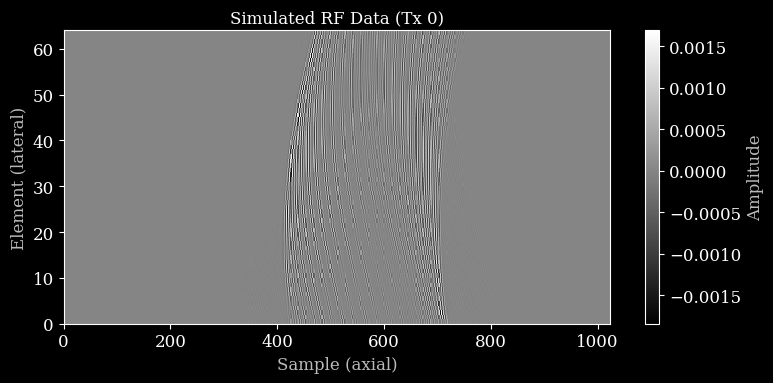

In [10]:
plot_rf(rf_data, title="Simulated RF Data (Tx 0)")

## Process simulated data with `zea.Pipeline`

We can process the simulated RF data using a Zea pipeline to obtain a B-mode image.

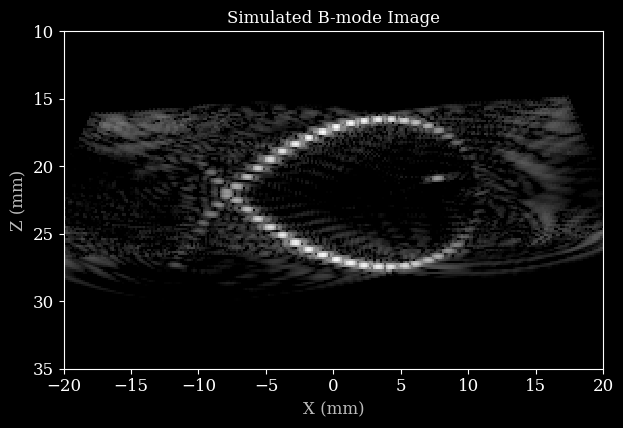

In [11]:
pipeline = zea.Pipeline.from_default(enable_pfield=False, with_batch_dim=False, baseband=False)
parameters = pipeline.prepare_parameters(probe, scan, dynamic_range=(-50, 0))
inputs = {pipeline.key: rf_data[0]}  # Use first batch

outputs = pipeline(**inputs, **parameters)
image = outputs[pipeline.output_key]

image = zea.display.to_8bit(image, dynamic_range=(-50, 0))

plt.figure()
plt.imshow(
    image,
    cmap="gray",
    extent=[
        scan.xlims[0] * 1e3,
        scan.xlims[1] * 1e3,
        scan.zlims[1] * 1e3,
        scan.zlims[0] * 1e3,
    ],
)
plt.xlabel("X (mm)")
plt.ylabel("Z (mm)")
plt.title("Simulated B-mode Image")
plt.tight_layout()

That's it! You have now simulated ultrasound RF data and reconstructed a B-mode image using `zea`.